<a href="https://colab.research.google.com/github/Dromedara/server/blob/main/aruco_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-anx4_l88
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-anx4_l88
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264356 sha256=90731d97cdde17f76621ec34fca2adc738de6bda6377c3bea86938437442aa4e
  Stored in directory: /tmp/pip-ephem-wheel-cache-y4tbxz_4/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 106166, done.
remote: Counting objects: 100% (41297/41297), done.
remote: Compressing objects: 100% (3282/3282), done.
remote: Total 106166 (delta 38250), reused 40549 (delta 37803), pack-reused 64869
Receiving objects: 100% (106166/106166), 208.50 MiB | 20.92 MiB/s, done.
Resolving deltas: 100% (91329/91329), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [ ]:
from google.colab import drive
drive.mount('./drive')

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


In [ ]:
!unzip ./drive/MyDrive/Laba/aruco/aruco-dataset.zip

Archive:  ./drive/MyDrive/Laba/aruco/aruco-dataset.zip
  inflating: labels.json             
   creating: data/
  inflating: data/aruco00001.png     
  inflating: data/aruco00011.png     
  inflating: data/aruco00021.png     
  inflating: data/aruco00031.png     
  inflating: data/aruco00041.png     
  inflating: data/aruco00051.png     
  inflating: data/aruco00061.png     
  inflating: data/aruco00071.png     
  inflating: data/aruco00081.png     
  inflating: data/aruco00091.png     
  inflating: data/aruco00101.png     
  inflating: data/aruco00111.png     
  inflating: data/aruco00121.png     
  inflating: data/aruco00131.png     
  inflating: data/aruco00141.png     
  inflating: data/aruco00151.png     
  inflating: data/aruco00161.png     
  inflating: data/aruco00171.png     
  inflating: data/aruco00181.png     
  inflating: data/aruco00191.png     
  inflating: data/aruco00201.png     
  inflating: data/aruco00211.png     
  inflating: data/aruco00221.png     
  inflating: d

In [ ]:
!cp drive/MyDrive/Laba/aruco/arucoMarkers.json drive/MyDrive/Laba/aruco/aruco-dataset/labels.json

In [ ]:
import torch.nn as nn

In [ ]:
import cv2

In [ ]:
from PIL import Image, ImageDraw

def mask_from_coco(img, target):
    img = np.array(img)
    
    polygon = target['segmentation'][0]
    img = Image.new('L', (img.shape[1], img.shape[0]), 0)
    try:
      ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
    except:
      print(target['image_id'])
      raise
      
    mask = np.array(img)
    
    return mask

In [ ]:
import json

In [ ]:
import copy

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import json


class ArucoDataset(torch.utils.data.Dataset):
    def __init__(self, root, annFile, transforms):
        self.root = root
        
        with open('drive/MyDrive/Laba/aruco/aruco-dataset/labels.json') as f:
          labels = json.load(f)

          self.annotations = list(filter(lambda x: len(x['segmentation'][0]) > 2, labels['annotations']))
          self.id2file = {
              meta['id']: meta['file_name']
              for meta in labels['images']
          }

        self.transforms = transforms
        
    def __getitem__(self, idx):
        if not isinstance(idx, int):
            idx = idx.item()

        target = copy.deepcopy(self.annotations[idx])
        
        # load images and masks
        img = cv2.imread(
            os.path.join(
                self.root, 
                self.id2file[target['image_id']]
            ),
            cv2.IMREAD_GRAYSCALE
        )

        mask = mask_from_coco(img, target)
        
        target['bbox'][2] += target['bbox'][0]
        target['bbox'][3] += target['bbox'][1]
        
        boxes = torch.Tensor([target['bbox']])
        
        target['masks'] = torch.as_tensor([mask], dtype=torch.uint8)
        target['boxes'] = boxes
        target['labels'] = torch.tensor([1], dtype=torch.int64)
        target['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target['iscrowd'] = torch.tensor([target['iscrowd']])
        target['image_id'] = torch.tensor([idx])
        target['id'] = torch.tensor([idx])

        del target['category_id']
        del target['segmentation']

        for key, value in target.items():
            target[key] = torch.tensor(value)
            
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.annotations)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
import utils

In [ ]:
# use our dataset and defined transformations
dataset = ArucoDataset('drive/MyDrive/Laba/aruco/aruco-dataset/data/', 'drive/MyDrive/Laba/aruco/aruco-dataset/labels.json', get_transform(train=True))
dataset_test = ArucoDataset('drive/MyDrive/Laba/aruco/aruco-dataset/data/', 'drive/MyDrive/Laba/aruco/aruco-dataset/labels.json', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_size = 320

dataset = torch.utils.data.Subset(dataset, indices[:-test_size])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-test_size:])

print(len(dataset), len(dataset_test))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False,
    collate_fn=utils.collate_fn)

1277 320


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
from engine import train_one_epoch, evaluate

In [ ]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/639]  eta: 8:46:19  lr: 0.000013  loss: 2.2287 (2.2287)  loss_classifier: 0.4980 (0.4980)  loss_box_reg: 0.0809 (0.0809)  loss_mask: 1.6375 (1.6375)  loss_objectness: 0.0117 (0.0117)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 49.4201  data: 4.9917
Epoch: [0]  [ 10/639]  eta: 7:29:17  lr: 0.000091  loss: 1.2526 (1.6397)  loss_classifier: 0.4153 (0.4298)  loss_box_reg: 0.0657 (0.0694)  loss_mask: 0.7596 (1.1006)  loss_objectness: 0.0396 (0.0381)  loss_rpn_box_reg: 0.0012 (0.0019)  time: 42.8582  data: 0.9291
Epoch: [0]  [ 20/639]  eta: 7:19:02  lr: 0.000169  loss: 0.9534 (1.1838)  loss_classifier: 0.3113 (0.3182)  loss_box_reg: 0.0673 (0.0785)  loss_mask: 0.5590 (0.7565)  loss_objectness: 0.0253 (0.0287)  loss_rpn_box_reg: 0.0012 (0.0018)  time: 42.2130  data: 0.5358
Epoch: [0]  [ 30/639]  eta: 7:12:38  lr: 0.000248  loss: 0.4832 (0.9592)  loss_classifier: 0.1307 (0.2538)  loss_box_reg: 0.1114 (0.0946)  loss_mask: 0.2274 (0.5870)  loss_objectness: 0.0096 (0.0219)  loss_rp

KeyboardInterrupt: ignored

In [ ]:
from torchvision.utils import draw_bounding_boxes

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#torch.save(model.state_dict(), 'drive/MyDrive/segmentation-model.pt')
model.load_state_dict(torch.load('drive/MyDrive/segmentation-model.pt'))
model.eval();

In [ ]:
import glob

In [ ]:
dataset.dataset.id2file.values()

dict_values(['aruco01181.png', 'mirroraruco03021.png', 'aruco01141.png', 'rotate_aruco02591.png', 'aruco02831.png', 'aruco02551.png', 'aruco00011.png', 'aruco02651.png', 'aruco02201.png', 'aruco03661.png', 'mirroraruco01871.png', 'aruco03651.png', 'mirroraruco02491.png', 'mirroraruco02351.png', 'rotate_aruco03171.png', 'mirroraruco02781.png', 'aruco00801.png', 'rotate_aruco00031.png', 'mirroraruco03321.png', 'rotate_aruco03291.png', 'rotate_aruco02281.png', 'mirroraruco02691.png', 'mirroraruco02111.png', 'rotate_aruco02081.png', 'aruco02341.png', 'mirroraruco00991.png', 'mirroraruco02801.png', 'mirroraruco02441.png', 'mirroraruco03261.png', 'rotate_aruco00371.png', 'aruco02771.png', 'aruco02901.png', 'aruco00791.png', 'rotate_aruco03441.png', 'aruco01491.png', 'rotate_aruco02731.png', 'mirroraruco00761.png', 'aruco01601.png', 'aruco02401.png', 'rotate_aruco00701.png', 'mirroraruco03551.png', 'rotate_aruco00311.png', 'rotate_aruco01051.png', 'aruco01261.png', 'rotate_aruco03321.png', 'r

In [ ]:
glob.glob('drive/MyDrive/Laba/aruco/aruco-dataset/data/*')[0]

'drive/MyDrive/Laba/aruco/aruco-dataset/data/aruco01451.png'

In [ ]:
other_images = set(glob.glob('drive/MyDrive/Laba/aruco/aruco-dataset/data/*'))
other_images.difference_update(list(map(lambda x: 'drive/MyDrive/Laba/aruco/aruco-dataset/data/' + x, dataset.dataset.id2file.values())))
other_images.difference_update(list(map(lambda x: 'drive/MyDrive/Laba/aruco/aruco-dataset/data/' + x, dataset_test.dataset.id2file.values())))
other_images = list(other_images)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
!pip install imantics

  Created wheel for imantics: filename=imantics-0.1.12-py3-none-any.whl size=16033 sha256=1047095ab968f74d832482190a98faded7e56fcaa0646634e20e6c53f755cacb
  Stored in directory: /root/.cache/pip/wheels/da/7c/3e/296fe3ed4eb3bd713e91dee0d0549f12f316d49939a64bdc96
Successfully built imantics


In [ ]:
from scipy.spatial import distance

In [ ]:
from imantics import Polygons, Mask


def show_mask(img, maskList, img_name='img.png'):
    alpha = 0.6
    beta = 1 - alpha
    alphaRaw=alpha*(img)
    betaBuffer=0
    for mask in maskList:
      betaBuffer += beta*(cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR))
      print(mask.shape)
    dst = np.uint8(alphaRaw+betaBuffer)
    plt.figure(figsize=(16, 9))
    plt.title(img_name)
    plt.imshow(dst)
    plt.show()


def get_mask(base_img, return_bbox=False, except_points=[]):
    img = get_transform(train=False)(base_img, {})[0]
    prediction = model(torch.FloatTensor([img.numpy()]).to(device))

    i = 0
    bboxList=[]
    maskList=[]
    while i < len(prediction[0]['boxes']):
        
        is_ok = True

        for point in except_points:
            if distance.euclidean((bboxList[i][0].item(), bboxList[i][1].item()), point) < 40:
                is_ok = False
                break

        if is_ok and prediction[0]['scores'][i]>0.7:
          bboxList.append(prediction[0]['boxes'][i].detach().cpu().numpy())
          maskList.append(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy())

        i += 1
    if len(bboxList)==0:
      del bboxList
      return None, None
    
    del prediction

    if return_bbox:
      
      return maskList, bboxList
    
    return maskList, None


def get_mask_segmentation(maskList):
    segmentationList=[]
    for mask in maskList:
      polygons = Mask(mask).polygons()
      segmentationList.append(polygons.segmentation)

    return segmentationList


def show_segmentation(image_path, except_points=[]):
    base_img = cv2.imread(image_path)
    maskList, _ = get_mask(base_img, except_points=except_points)
    show_mask(base_img, maskList)


def get_image_coco_properties(image_path, image_id, except_points=[]):
    base_img = cv2.imread(image_path)
    maskList, bboxList = get_mask(base_img, return_bbox=True, except_points=except_points)

    if maskList is None:
        return None, None

    segmentationList = get_mask_segmentation(maskList)

    annotationList = []
    for index,bbox in enumerate(bboxList):
      annotation = {
        'bbox': [round(bbox[0]), round(bbox[1]), round(bbox[2] - bbox[0]), round(bbox[3] - bbox[1])],
        'id': -1,
        'image_id': image_id,
        'category_id': 91,
        'iscrowd': 0,
        'segmentation': segmentationList[index]
      }
      annotationList.append(annotation)

    image = {
        "date_captured": "",
        "file_name": os.path.basename(image_path),
        "height": base_img.shape[0],
        "id": image_id,
        "license": 0,
        "url": "",
        "width": base_img.shape[1]
    }

    return image, annotationList

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def segment_and_coco_annotate(images_path, except_points=[]):
    images = []
    coco_annotations = []

    for i, image_path in tqdm(enumerate(images_path), total=len(images_path)):
        image, annotationList = get_image_coco_properties(
            images_path[i],
            2000 + i,
            except_points
        )

        if image is None:
            continue
        for annotation in annotationList:
          coco_annotations.append(annotation)
        images.append(image)

    return images, coco_annotations

In [ ]:
def view_examples(images, coco_annotations, images_dir='drive/MyDrive/Laba/aruco/aruco-dataset/data/', n=3):
    indices = np.random.choice([i for i in range(len(images))], n)
    images = np.array(images)
    coco_annotations = np.array(coco_annotations)
    for image in images[indices]:
        print(image)
        img = cv2.imread(os.path.join(images_dir, image['file_name']))
        maskList = []
        for i in range(len(coco_annotation)):
          if coco_annotation[i]["image_id"]==image["id"]:
            print(coco_annotation[i])
            mask = mask_from_coco(img, coco_annotation[i])
            maskList.append(mask*255)
        show_mask(img, maskList, img_name=image['file_name'])

In [ ]:
import os
import cv2
from tqdm.notebook import tqdm


def get_frames(video_path, save_path):
    video_name = os.path.basename(video_path)
    vidcap = cv2.VideoCapture(video_path)

    success,image = vidcap.read()
    count = 0
    success = True

    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = list(range(0, total_frames, 3))  # какие фреймы нужно вырезать

    for frame_number in tqdm(frames, leave=False):
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = vidcap.read()
        cv2.imwrite(os.path.join(save_path, '%s_frame%d.jpg' % (video_name, frame_number)), frame)

In [ ]:
!mkdir video_1

In [ ]:
get_frames('/content/drive/MyDrive/videoDrone.mp4', './video_1/')
get_frames('/content/drive/MyDrive/videoDrone2.mp4', './video_1/')
get_frames('/content/drive/MyDrive/videoDrone3.mp4', './video_1/')
get_frames('/content/drive/MyDrive/videoDrone4.mp4', './video_1/')
get_frames('/content/drive/MyDrive/videoDrone5.mp4', './video_1/')
get_frames('/content/drive/MyDrive/videoDrone6.mp4', './video_1/')
get_frames('/content/drive/MyDrive/videoDrone7.mp4', './video_1/')
get_frames('/content/drive/MyDrive/videoDrone8.mp4', './video_1/')

  0%|          | 0/1271 [00:00<?, ?it/s]

  0%|          | 0/825 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/684 [00:00<?, ?it/s]

  0%|          | 0/1371 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

In [ ]:
ls

coco_eval.py   data/   engine.py    __pycache__/  transforms.py  video_1/
coco_utils.py  drive/  labels.json  sample_data/  utils.py       vision/


In [ ]:
images, coco_annotation = segment_and_coco_annotate(
    glob.glob('./video_1/*'),
    #except_points=[(1192, 1012), (1034, 743), (66, 190), (1227, 1018), 
    #               (843, 302), (504, 507), (1512,  812), (1000, 785),
    #               (77, 316), (776, 325), (1741, 617), (1575, 681), (1000, 729),
    #               (1693, 1037), (1065, 154), (1763, 1051), (432, 36), (1673, 1023),
    #               (484, 22), (1845, 311)]
)

  0%|          | 0/6418 [00:00<?, ?it/s]

In [ ]:
print(glob.glob('./video_1/*'))

['./video_1/videoDrone.mp4_frame3360.jpg', './video_1/videoDrone5.mp4_frame2800.jpg', './video_1/videoDrone.mp4_frame3560.jpg', './video_1/videoDrone5.mp4_frame4080.jpg', './video_1/videoDrone.mp4_frame1280.jpg', './video_1/videoDrone.mp4_frame1720.jpg', './video_1/videoDrone2.mp4_frame1160.jpg', './video_1/videoDrone4.mp4_frame80.jpg', './video_1/videoDrone8.mp4_frame720.jpg', './video_1/videoDrone.mp4_frame2760.jpg', './video_1/videoDrone2.mp4_frame120.jpg', './video_1/videoDrone.mp4_frame3200.jpg', './video_1/videoDrone2.mp4_frame880.jpg', './video_1/videoDrone3.mp4_frame640.jpg', './video_1/videoDrone3.mp4_frame1640.jpg', './video_1/videoDrone2.mp4_frame1960.jpg', './video_1/videoDrone.mp4_frame3120.jpg', './video_1/videoDrone3.mp4_frame1600.jpg', './video_1/videoDrone.mp4_frame3040.jpg', './video_1/videoDrone.mp4_frame2680.jpg', './video_1/videoDrone.mp4_frame1480.jpg', './video_1/videoDrone3.mp4_frame1400.jpg', './video_1/videoDrone.mp4_frame160.jpg', './video_1/videoDrone.mp4_fr

In [ ]:
print(len(images))

4033


{'date_captured': '', 'file_name': 'videoDrone.mp4_frame3342.jpg', 'height': 478, 'id': 3803, 'license': 0, 'url': '', 'width': 848}
{'bbox': [363, 139, 88, 105], 'id': -1, 'image_id': 3803, 'category_id': 91, 'iscrowd': 0, 'segmentation': [[362, 136, 362, 241, 363, 241, 364, 242, 368, 242, 369, 241, 376, 241, 377, 242, 378, 242, 379, 243, 382, 243, 383, 244, 389, 244, 390, 245, 452, 245, 452, 138, 451, 137, 443, 137, 442, 138, 438, 138, 437, 137, 427, 137, 426, 136]]}
(478, 848)


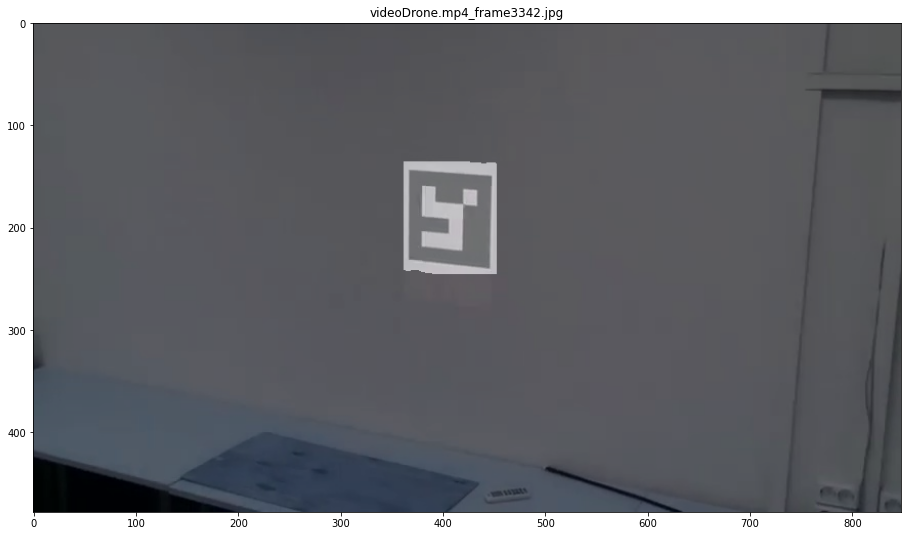

{'date_captured': '', 'file_name': 'videoDrone6.mp4_frame984.jpg', 'height': 478, 'id': 4951, 'license': 0, 'url': '', 'width': 848}
{'bbox': [182, 336, 230, 141], 'id': -1, 'image_id': 4951, 'category_id': 91, 'iscrowd': 0, 'segmentation': [[240, 333, 239, 334, 238, 334, 237, 335, 237, 336, 236, 337, 236, 346, 234, 348, 233, 348, 232, 349, 232, 350, 231, 351, 231, 352, 230, 353, 229, 353, 229, 354, 228, 355, 228, 366, 226, 368, 224, 368, 223, 369, 222, 369, 222, 370, 221, 371, 221, 372, 220, 373, 220, 377, 219, 378, 219, 381, 218, 382, 217, 382, 216, 383, 215, 383, 214, 384, 213, 384, 213, 385, 212, 386, 212, 391, 211, 392, 211, 398, 210, 399, 208, 399, 205, 402, 205, 403, 204, 404, 204, 405, 203, 406, 203, 412, 201, 414, 200, 414, 197, 417, 197, 418, 196, 419, 196, 420, 195, 421, 195, 428, 193, 430, 192, 430, 191, 431, 191, 432, 187, 436, 187, 440, 186, 441, 186, 443, 185, 444, 184, 444, 183, 445, 182, 445, 181, 446, 181, 447, 180, 448, 180, 449, 179, 450, 179, 454, 178, 455, 178, 47

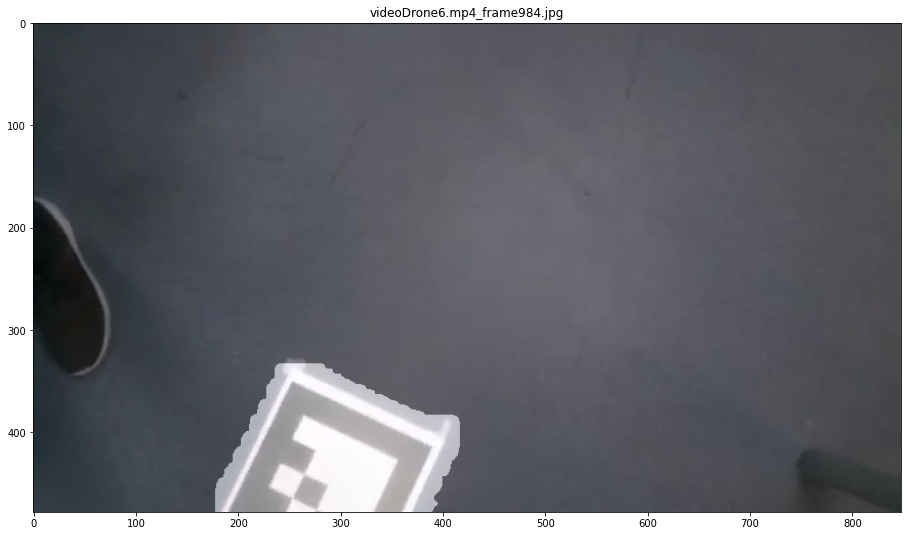

{'date_captured': '', 'file_name': 'videoDrone.mp4_frame2892.jpg', 'height': 478, 'id': 6224, 'license': 0, 'url': '', 'width': 848}
{'bbox': [608, 281, 68, 20], 'id': -1, 'image_id': 6224, 'category_id': 91, 'iscrowd': 0, 'segmentation': [[623, 280, 622, 281, 621, 281, 620, 282, 619, 282, 617, 284, 616, 284, 613, 287, 611, 287, 610, 288, 609, 288, 609, 289, 608, 290, 607, 290, 606, 291, 606, 294, 607, 295, 613, 295, 614, 296, 618, 296, 619, 297, 622, 297, 623, 298, 627, 298, 628, 299, 631, 299, 632, 300, 634, 300, 635, 301, 645, 301, 646, 302, 661, 302, 662, 301, 664, 301, 665, 300, 666, 300, 667, 299, 668, 299, 668, 298, 669, 297, 671, 297, 674, 294, 675, 294, 676, 293, 676, 287, 675, 286, 672, 286, 671, 285, 666, 285, 665, 284, 662, 284, 661, 283, 654, 283, 653, 282, 648, 282, 647, 281, 641, 281, 640, 280]]}
{'bbox': [547, 120, 52, 55], 'id': -1, 'image_id': 6224, 'category_id': 91, 'iscrowd': 0, 'segmentation': [[546, 119, 546, 175, 600, 175, 600, 119]]}
{'bbox': [801, 79, 46, 60],

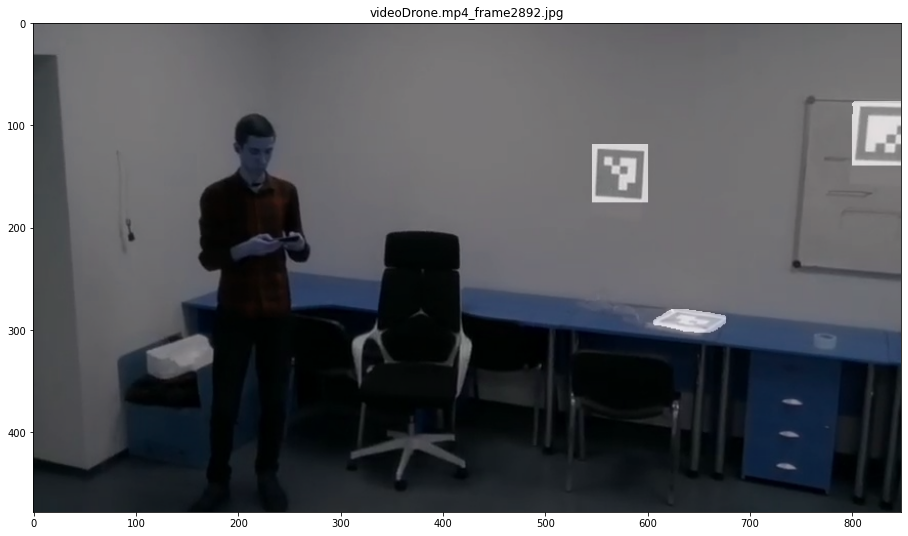

{'date_captured': '', 'file_name': 'videoDrone3.mp4_frame1227.jpg', 'height': 478, 'id': 4949, 'license': 0, 'url': '', 'width': 848}
{'bbox': [99, 152, 66, 102], 'id': -1, 'image_id': 4949, 'category_id': 91, 'iscrowd': 0, 'segmentation': [[97, 150, 97, 251, 98, 252, 98, 254, 99, 255, 103, 255, 104, 254, 105, 255, 166, 255, 166, 150]]}
(478, 848)


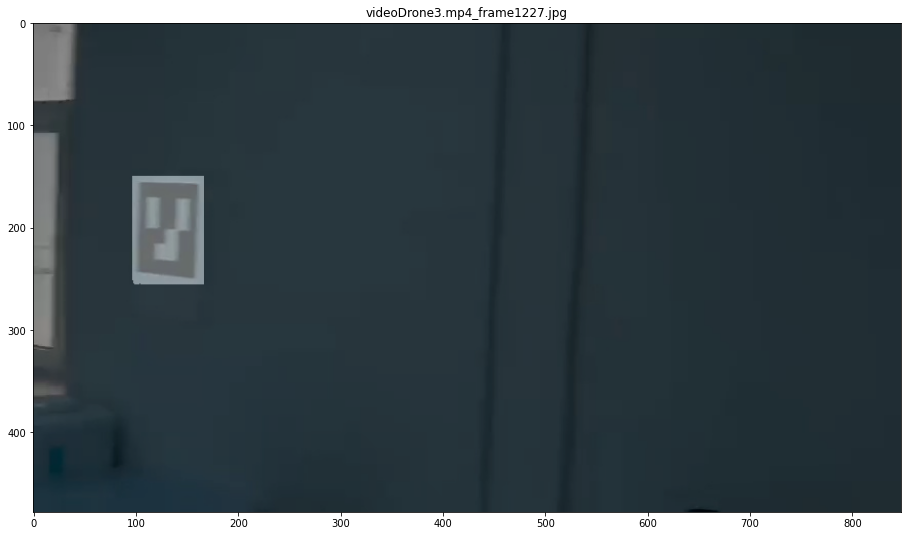

{'date_captured': '', 'file_name': 'videoDrone6.mp4_frame1464.jpg', 'height': 478, 'id': 3518, 'license': 0, 'url': '', 'width': 848}
{'bbox': [83, 59, 189, 210], 'id': -1, 'image_id': 3518, 'category_id': 91, 'iscrowd': 0, 'segmentation': [[115, 55, 113, 57, 112, 57, 111, 58, 110, 58, 109, 59, 109, 60, 108, 61, 108, 63, 107, 64, 107, 79, 106, 80, 106, 83, 103, 86, 102, 86, 102, 87, 101, 88, 101, 91, 100, 92, 100, 101, 98, 103, 98, 104, 97, 105, 97, 107, 95, 109, 95, 111, 94, 112, 94, 117, 93, 118, 93, 133, 90, 136, 90, 137, 89, 138, 89, 139, 88, 140, 88, 144, 87, 145, 87, 148, 86, 149, 86, 154, 84, 156, 84, 157, 83, 158, 83, 159, 81, 161, 81, 163, 80, 164, 80, 175, 79, 176, 79, 217, 80, 218, 80, 220, 81, 221, 81, 224, 82, 225, 83, 225, 84, 226, 87, 226, 88, 227, 96, 227, 98, 229, 99, 229, 100, 230, 100, 231, 101, 232, 102, 232, 103, 233, 106, 233, 107, 234, 113, 234, 118, 239, 119, 239, 121, 241, 123, 241, 124, 242, 134, 242, 138, 246, 139, 246, 140, 247, 141, 247, 142, 248, 146, 248,

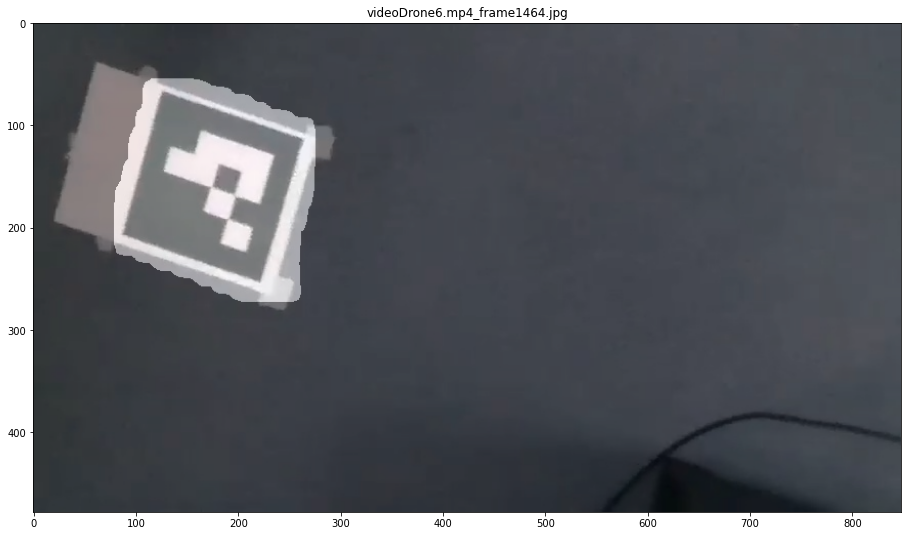

{'date_captured': '', 'file_name': 'videoDrone2.mp4_frame2103.jpg', 'height': 478, 'id': 6819, 'license': 0, 'url': '', 'width': 848}
{'bbox': [302, 128, 44, 55], 'id': -1, 'image_id': 6819, 'category_id': 91, 'iscrowd': 0, 'segmentation': [[301, 127, 301, 184, 346, 184, 346, 127]]}
{'bbox': [782, 150, 63, 71], 'id': -1, 'image_id': 6819, 'category_id': 91, 'iscrowd': 0, 'segmentation': [[783, 148, 782, 149, 781, 149, 781, 196, 782, 197, 782, 198, 783, 199, 786, 199, 787, 200, 787, 201, 788, 201, 789, 202, 790, 202, 792, 204, 794, 204, 795, 205, 795, 207, 797, 209, 798, 209, 799, 210, 799, 211, 800, 212, 800, 214, 801, 214, 802, 215, 802, 217, 803, 218, 803, 219, 804, 220, 804, 222, 806, 222, 807, 223, 846, 223, 846, 150, 845, 149, 830, 149, 829, 148]]}
(478, 848)
(478, 848)


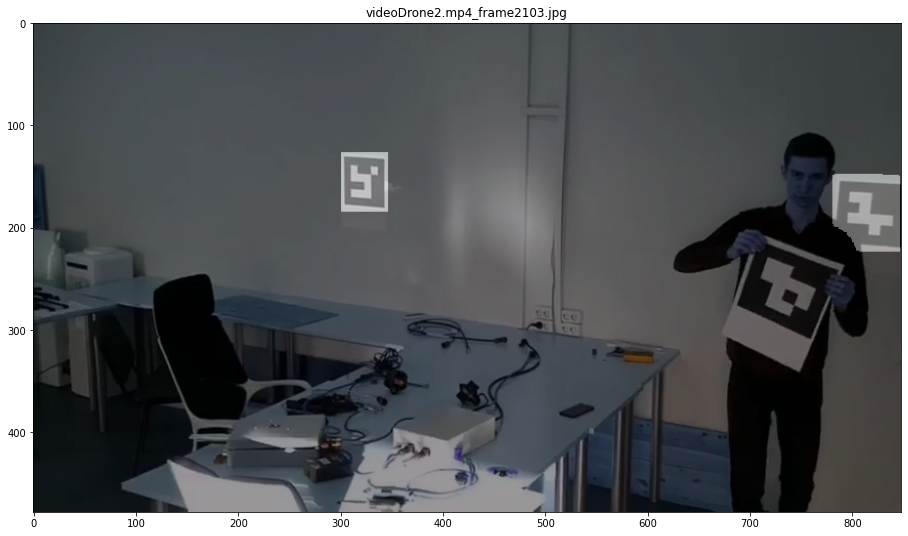

{'date_captured': '', 'file_name': 'videoDrone2.mp4_frame159.jpg', 'height': 478, 'id': 7140, 'license': 0, 'url': '', 'width': 848}
{'bbox': [387, 121, 73, 77], 'id': -1, 'image_id': 7140, 'category_id': 91, 'iscrowd': 0, 'segmentation': [[386, 119, 385, 120, 385, 198, 386, 199, 460, 199, 461, 198, 461, 120, 460, 119]]}
(478, 848)


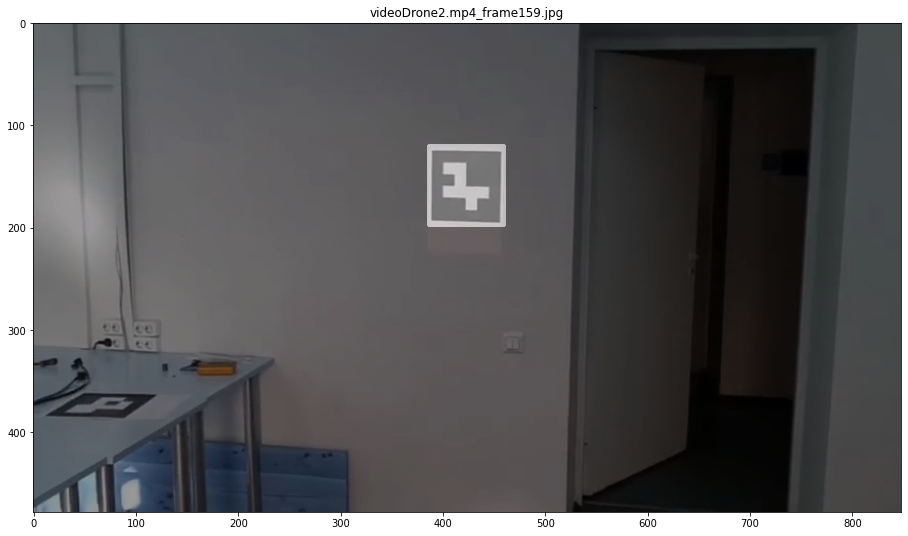

{'date_captured': '', 'file_name': 'videoDrone7.mp4_frame474.jpg', 'height': 478, 'id': 4408, 'license': 0, 'url': '', 'width': 848}
{'bbox': [409, 0, 211, 168], 'id': -1, 'image_id': 4408, 'category_id': 91, 'iscrowd': 0, 'segmentation': [[406, 0, 406, 1, 405, 2, 405, 169, 407, 171, 623, 171, 624, 170, 624, 0]]}
(478, 848)


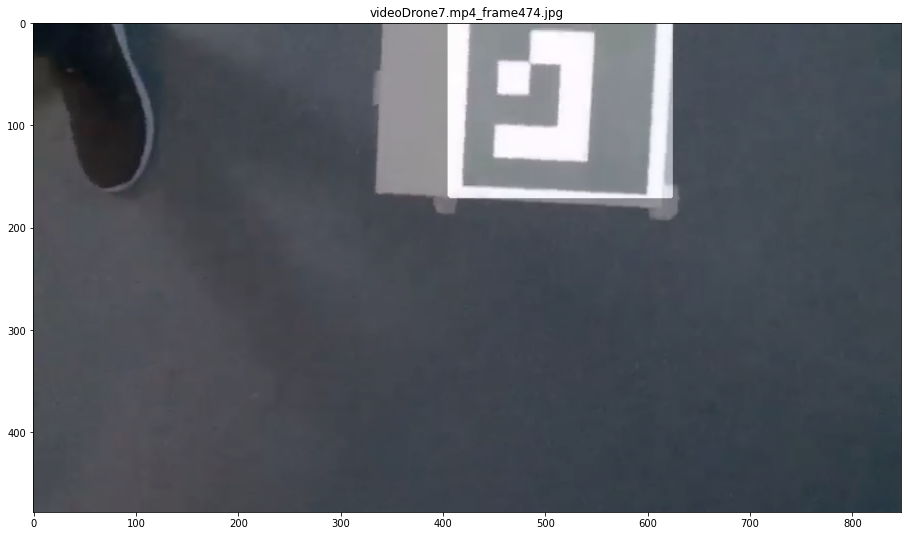

{'date_captured': '', 'file_name': 'videoDrone.mp4_frame3680.jpg', 'height': 478, 'id': 2861, 'license': 0, 'url': '', 'width': 848}
{'bbox': [727, 1, 100, 66], 'id': -1, 'image_id': 2861, 'category_id': 91, 'iscrowd': 0, 'segmentation': [[726, 0, 725, 1, 725, 68, 826, 68, 827, 67, 828, 67, 828, 0]]}
(478, 848)


KeyboardInterrupt: ignored

In [ ]:
view_examples(images, coco_annotation, images_dir='./video_1', n=247)


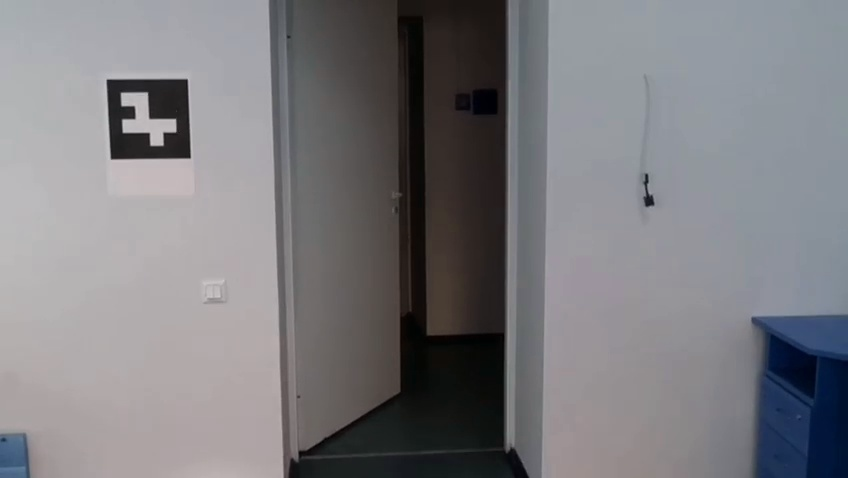

In [ ]:
import plotly.express as px

px.imshow(cv2.imread('./video_1/videoDrone2.mp4_frame108.jpg'))

In [ ]:
import plotly.express as px

px.imshow(cv2.imread('./video_1/videoDrone4.mp4_frame880.jpg'))

TypeError: ignored

In [ ]:
show_segmentation(
    './video_1/videoDrone4.mp4_frame880.jpg',
    #except_points=[(1192, 1012), (1034, 743), (66, 190), (1227, 1018), 
    #               (843, 302), (504, 507), (1512,  812), (1000, 785),
    #               (77, 316), (776, 325), (1741, 617), (1575, 681), (1000, 729)]
)

TypeError: ignored

In [ ]:
# 1 1 348
# 1 2 486

# 1 1 282
# 1 1 360
# 1 1 288


# 1 2 450
# 1 2 798
# 1 2 858

In [ ]:
with open('drive/MyDrive/Laba/aruco/arucoMarkers.json', 'r') as fw:
    labels = json.load(fw)
    labels['images'].extend(images)
    labels['annotations'].extend(coco_annotation)
    with open('drive/MyDrive/Laba/aruco/autosegmented_coco_4000.json', 'w') as fw:
        json.dump(labels, fw)

In [ ]:
!cp video_1/* ./aruco-dataset-auto4000/data/

In [ ]:
ls

coco_eval.py   data/   engine.py    __pycache__/  transforms.py  video_1/
coco_utils.py  drive/  labels.json  sample_data/  utils.py       vision/


In [ ]:
!zip -r aruco-dataset-auto4000.zip ./aruco-dataset-auto4000
!mv aruco-dataset-auto4000.zip ./drive/MyDrive/Laba/aruco/

Выходные данные были обрезаны до нескольких последних строк (5000).
  adding: aruco-dataset-auto4000/data/videoDrone2.mp4_frame1713.jpg (deflated 2%)
  adding: aruco-dataset-auto4000/data/videoDrone.mp4_frame3387.jpg (deflated 4%)
  adding: aruco-dataset-auto4000/data/videoDrone5.mp4_frame852.jpg (deflated 1%)
  adding: aruco-dataset-auto4000/data/videoDrone5.mp4_frame3495.jpg (deflated 1%)
  adding: aruco-dataset-auto4000/data/videoDrone5.mp4_frame1239.jpg (deflated 1%)
  adding: aruco-dataset-auto4000/data/videoDrone3.mp4_frame1701.jpg (deflated 0%)
  adding: aruco-dataset-auto4000/data/videoDrone5.mp4_frame2271.jpg (deflated 1%)
  adding: aruco-dataset-auto4000/data/videoDrone.mp4_frame2840.jpg (deflated 1%)
  adding: aruco-dataset-auto4000/data/videoDrone2.mp4_frame96.jpg (deflated 2%)
  adding: aruco-dataset-auto4000/data/videoDrone6.mp4_frame726.jpg (deflated 0%)
  adding: aruco-dataset-auto4000/data/videoDrone3.mp4_frame24.jpg (deflated 3%)
  adding: aruco-dataset-auto4000/data/